In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import random
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import visualization as vis
import pandas as pd
import glob
from sklearn.decomposition import PCA
import data_generator as dataset
import os 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Generation

In [ ]:
REPEAT = 1500

df = []
for i in tqdm(range(REPEAT)):
    sim = dataset.gen_cluster(num=np.random.randint(500, 1500), seed=i)
    df.append(sim)

for i in tqdm(range(REPEAT)):
    sim = dataset.gen_trajectory(num=np.random.randint(500,1500),seed=i)
    df.append(sim)

for i in tqdm(range(REPEAT)):
    np.random.seed(i)
    sim, ind = dataset.gen_random(num=np.random.randint(500,1500),mode=dataset.genType.CLUSTER,seed=i)
    df.append(sim)

for i in tqdm(range(REPEAT)):
    np.random.seed(i)
    sim, ind = dataset.gen_random(num=np.random.randint(500,1500),mode=dataset.genType.TRAJECTORY,seed=i)
    df.append(sim)
    
os.makedirs('scatterplots', exist_ok=True)
ct=0
for a in tqdm(df):
    ct += 1
    fig = plt.figure(figsize=(1.5, 1.5))
    plt.scatter(a[:, 0], a[:, 1], s=1)
    plt.savefig(f'scatterplots/{ct}.png')
    plt.close()

ORIGINAL_META_SCORES = []
OUR_META_SCORES = []
for df in tqdm(df):
    score = vis.scoring(df)
    OUR_META_SCORES.append(score)
os.makedirs('data', exist_ok=True)
np.save('data/our_meta_scores.npy', np.array(OUR_META_SCORES))

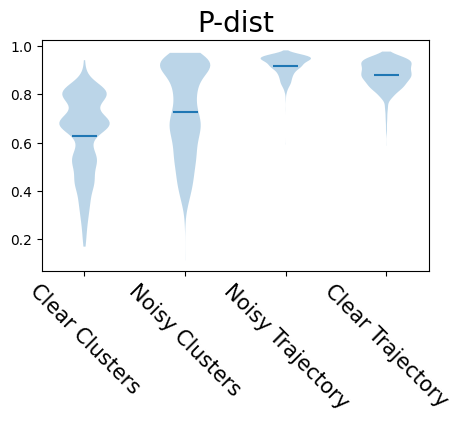

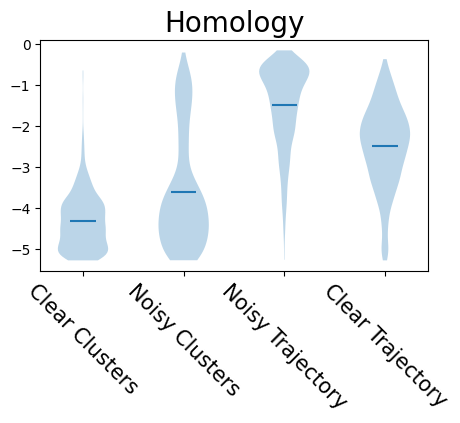

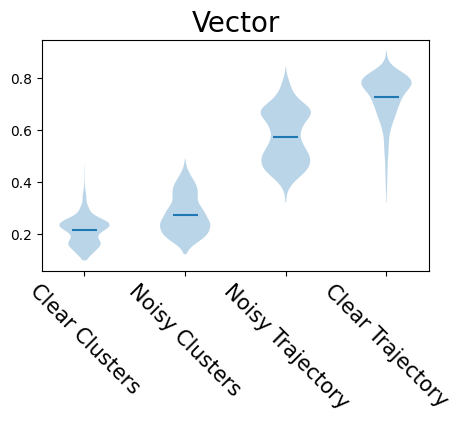

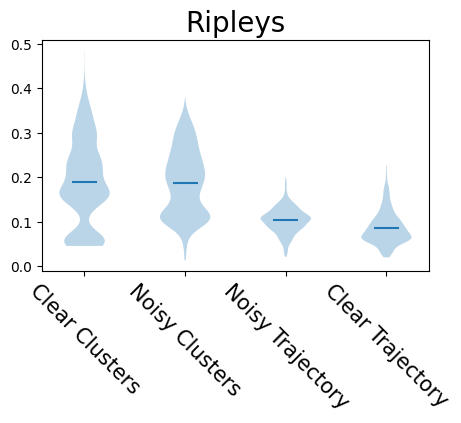

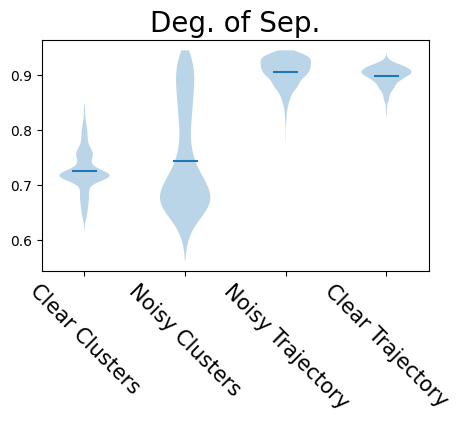

In [5]:
REPEAT = 1500
META_SCORES = list(np.load('data/our_meta_scores.npy')) # Loading pre-computed scores for simulated datasets
clstr = META_SCORES[:REPEAT]
traj = META_SCORES[REPEAT:2*REPEAT]
clstr_r1 = META_SCORES[2*REPEAT:3*REPEAT]
traj_r1 = META_SCORES[3*REPEAT:4*REPEAT]

npy_sim = np.array(META_SCORES)
feature_names = ['P-dist','Homology','Vector','Ripleys','Deg. of Sep.']
for i in range(len(feature_names)):
    feat = i
    plt.figure(figsize=(5,3))
    plt.violinplot([np.array(clstr)[:,feat],
                    np.array(clstr_r1)[:,feat],
                    np.array(traj_r1)[:,feat],
                    np.array(traj)[:,feat]],
                  showmeans = True, showextrema=False)
    plt.title(feature_names[i], fontsize = 20)
    plt.xticks(fontsize=15, rotation=315)
    plt.xticks([1, 2, 3, 4], ['Clear Clusters','Noisy Clusters','Noisy Trajectory','Clear Trajectory'])
    plt.show()

/home/linsfa/Documents/BIO-INFO-2025/src/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


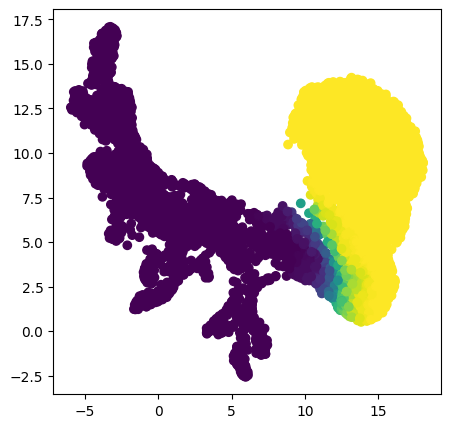

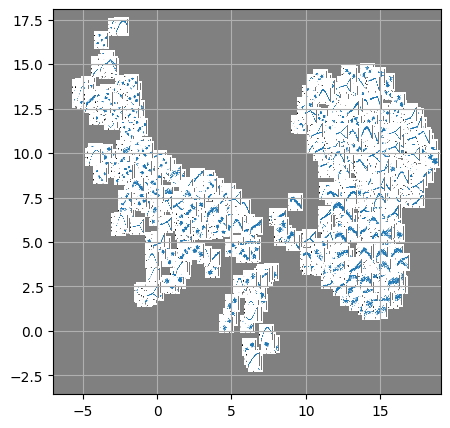

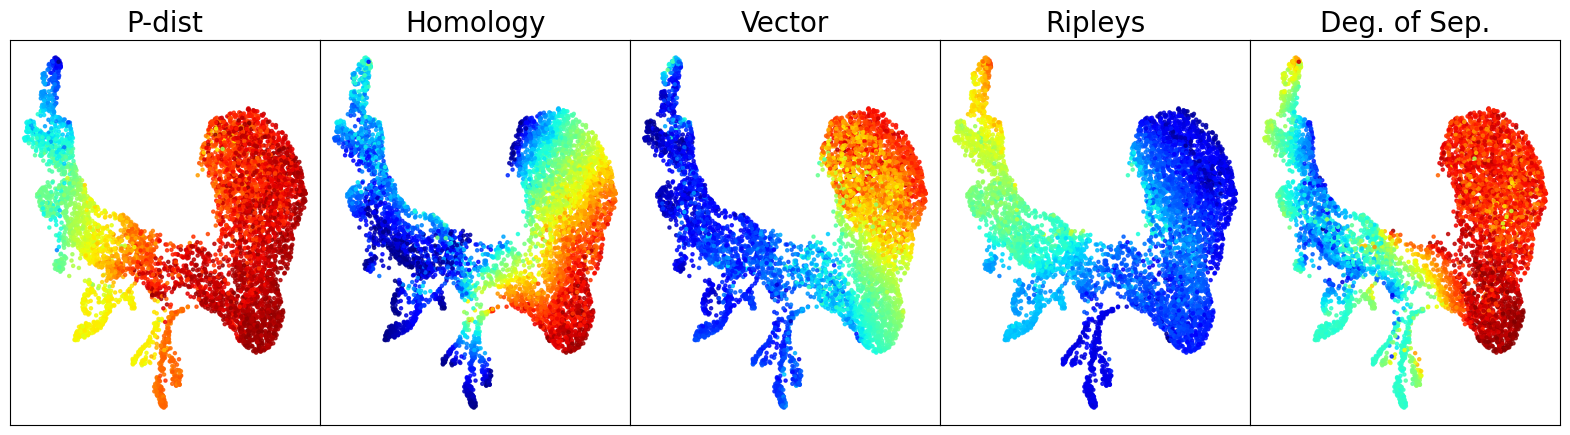

In [6]:
metric = 'euclidean'
seed = 1
n_neighbors = 50
min_dist = 0.6
figsize = 5

scaler = StandardScaler()
tmp_np = scaler.fit_transform(npy_sim)
tmp_reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2,random_state=seed,min_dist=min_dist, metric=metric)
embedding = tmp_reducer.fit_transform(tmp_np)
assert isinstance(embedding, np.ndarray)
classes = ['Clear Clusters','Clear Trajectory','Noisy Trajectory','Noisy Clusters']

c = [0]*REPEAT + [1]*REPEAT + [0]*REPEAT + [1]*REPEAT

neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(embedding, c)

b = neigh.predict(embedding)
p = neigh.predict_proba(embedding)[:,1] #type: ignore
plt.show()
plt.figure(figsize=(figsize,figsize))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.show()

def plotImage(x, y, im):
    bb = Bbox.from_bounds(x,y,1,1)  
    bb2 = TransformedBbox(bb,ax.transData)
    bbox_image = BboxImage(bb2,
                        norm = None,
                        origin=None,
                        clip_on=False)

    bbox_image.set_data(im)
    ax.add_artist(bbox_image)
    
fig = plt.figure(figsize=(figsize,figsize))
ax = fig.add_subplot(111)
ax.grid()
ax.set_facecolor('gray')
for i in range(len(npy_sim)):
    if random.uniform(0, 1) < 0.1: 
        plotImage(embedding[i][0], embedding[i][1], plt.imread('scatterplots/{}.png'.format(i+1)))
    else:
        continue

# Set the x and y limits
border = 1
ax.set_ylim(np.min(embedding, axis =0)[1]-border,np.max(embedding, axis =0)[1]+border)
ax.set_xlim(np.min(embedding, axis =0)[0]-border,np.max(embedding, axis =0)[0]+border)
plt.show()

fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(5):
    axs[i].scatter(embedding[:,0],embedding[:,1], s=5,c= npy_sim[:len(embedding),i], cmap = 'jet', alpha = 0.8)
    axs[i].set_title(feature_names[i], fontsize=20)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [ ]:
def load_benchmark_data(pca_dim = 20):# -> tuple[list[Any], list[Any]]:
    np.random.seed(seed=42)
    files = []
    for file in glob.glob("data/benchmarkfiles/*.csv"):
        files.append(file)
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

def load_organ_data(pca_dim = 20):
    np.random.seed(42)
    files = []
    for file in glob.glob("data/scHuman/*.csv"):
        files.append(file)
    df_real = []
    files_used = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        if len(npy_array) < 100:
            continue
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
        files_used.append(file)
    return df_real,files_used

def load_cluster_data(pca_dim = 20):
    np.random.seed(42)
    files = []
    for file in glob.glob("data/datacuration/*.csv"):
        files.append(file)
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

df_benchmark,benchmark_files = load_benchmark_data()
df_organ,organ_files = load_organ_data()
df_cluster,cluster_files = load_cluster_data()

all_dfs = df_benchmark + df_organ + df_cluster
all_files = benchmark_files + organ_files + cluster_files

META_SCORES = []

for df in tqdm(all_dfs, position=0, leave=True):
    scores = vis.scoring(df)
    META_SCORES.append(scores)
npy_real = np.stack(META_SCORES)
np.save('data/real_data_scores.npy',npy_real)

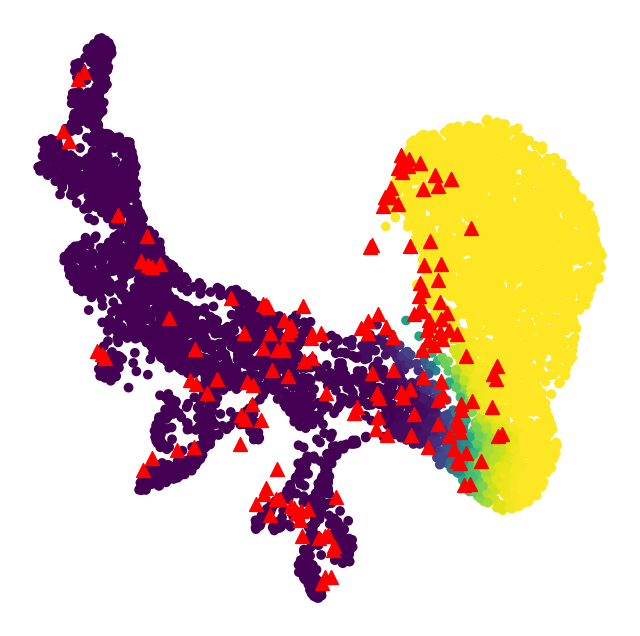

In [8]:
npy_real = np.load('data/real_data_scores.npy')
real_embs = []
for i in range(len(npy_real)):
    tmp_real = scaler.transform(npy_real[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    real_embs.append(d2_real_embedding)

np_real_emb = np.array(real_embs)
np_real_emb = np_real_emb.reshape((len(real_embs),2))

plt.figure(figsize=(8,8))
assert isinstance(embedding, np.ndarray) # check for embedding type warning
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_real_emb[:,0],np_real_emb[:,1], c = 'r', s = 100,  marker="^")
plt.axis('off')
plt.show()

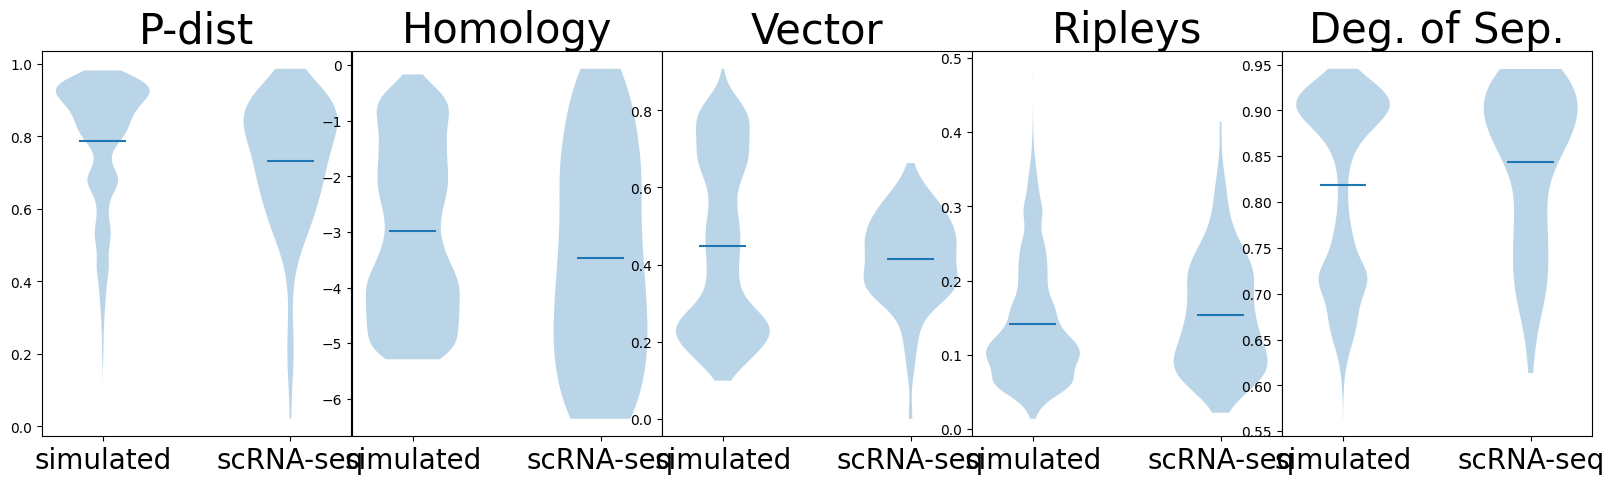

In [9]:
all_sims = np.vstack([np.array(clstr),
                    np.array(clstr_r1),
                    np.array(traj_r1),
                    np.array(traj)])
# add spacing between graphs

fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i in range(5):
    feat = i
    axs[i].violinplot([all_sims[:,feat],npy_real[:,feat]],
                  showmeans = True, showextrema=False)
    axs[i].set_xticks([1, 2], ['simulated','scRNA-seq'], fontsize=20)
    axs[i].set_title(feature_names[i],fontsize=30)

In [10]:
## table generation 
data_type = pd.read_csv('data/data_type.csv')
names = []
gold_silver = []
for name in data_type['id']:
    tmp = name.split('/')[-1]
    gold_silver.append(name.split('/')[1])
    names.append(tmp)
data_type['id'] = names

traj_type = []
for name in benchmark_files:
    a = name.split('benchmarkfiles/')[1].split('.rds')[0]
    tt = data_type[data_type['id'] == a]['trajectory_type']
    label = np.array(tt)[0]
    traj_type.append(label)

for name in organ_files:
    traj_type.append('organ')
    
for name in cluster_files:
    traj_type.append('cluster')

COUNTS = []
for tt in np.unique(np.array(traj_type)):


    query = np.array([np_real_emb[np.array(traj_type) == tt,0],np_real_emb[np.array(traj_type) == tt,1]]).T
    prediction = neigh.predict(query)
    count_cluster=len(np.where(prediction==0)[0])
    count_traj=len(np.where(prediction==1)[0])

    COUNTS.append([count_cluster,count_traj])
fig4_c = pd.DataFrame(COUNTS,columns=['predicted clusters','predicted trajectory'],index = np.unique(np.array(traj_type)))
fig4_c

,predicted clusters,predicted trajectory
acyclic_graph,1,0
bifurcation,7,6
cluster,21,11
convergence,1,0
cycle,0,2
disconnected_graph,21,4
linear,19,20
multifurcation,4,5
organ,21,7
tree,17,2


In [11]:
fig4_c.sum()

predicted clusters      112
predicted trajectory     57
dtype: int64

# Other Datasets


In [ ]:
def load_brain_data(pca_dim = 20):# -> tuple[list[Any], list[Any]]:
    np.random.seed(seed=42)
    files = []
    for file in glob.glob("data/brain/*.csv"):
        files.append(file)
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

brain_dfs, brain_files = load_brain_data()

META_SCORES = []
for df in tqdm(brain_dfs, position=0, leave=True):
    scores = vis.scoring(df)
    META_SCORES.append(scores)
npy_real = np.stack(META_SCORES)
np.save('data/brain/brain.npy',npy_real)

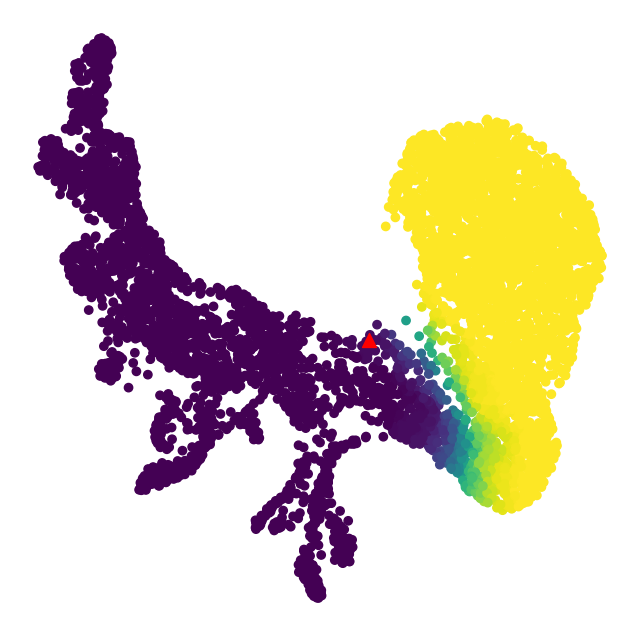

In [13]:
npy_real = np.load('data/brain/brain.npy')
real_embs = []
for i in range(len(npy_real)):
    tmp_real = scaler.transform(npy_real[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    real_embs.append(d2_real_embedding)

np_real_emb = np.array(real_embs)
np_real_emb = np_real_emb.reshape((len(real_embs),2))

plt.figure(figsize=(8,8))
assert isinstance(embedding, np.ndarray) # check for embedding type warning
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_real_emb[:,0],np_real_emb[:,1], c = 'r', s = 100,  marker="^")
plt.axis('off')
plt.show()

In [14]:
query = np.array([np_real_emb[:,0],np_real_emb[:,1]]).T
prediction = neigh.predict(query)
count_cluster=len(np.where(prediction==0)[0])
count_traj=len(np.where(prediction==1)[0])
print(f'Brain data: {count_cluster} clusters, {count_traj} trajectories')

Brain data: 1 clusters, 0 trajectories
